In [1]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import uproot3 as uproot

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [25]:
ofolder="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/results/"
os.system("mkdir -p "+ofolder)

0

In [26]:
def loadTheory(tbin):
    theory_pred_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/theory_pred/"
    ''' Load the theory curves for the different m-projections '''
    theoryCurves=pd.read_csv(theory_pred_floc+"Waves_bin"+str(tbin)+".txt",sep='  ',
                           names=["D0++", "D1++", "D2++", "D1--", "D0+-", "D1+-"], engine='python')
    theoryCurves=theoryCurves.reset_index()
    theoryCurves.rename(columns={"index":"mass"},inplace=True)
    return theoryCurves

def loadMergedPols(fileName,histBaseName,pols):
    '''
    We use amptools' plotter program to make histograms that were output into separate root files
    Use this function to load the root file and grab the histogram you want ~ integrated over some set of polarizations
    '''
    totalValues=0
    for pol in pols:
        hist=uproot.open(fileName)["EtaPi0_"+pol+"_"+histBaseName]
        edges=hist.edges
        width=edges[1]-edges[0]
        value=hist.values
        totalValues+=value
    return totalValues, edges, width

def relBW(x,particle_mass,width):
    ''' Equation for relativistic breit-wigner'''
    gamma=np.sqrt(particle_mass*particle_mass*(particle_mass*particle_mass+width*width))
    k=2*np.sqrt(2)*particle_mass*width*gamma/np.pi/np.sqrt(particle_mass*particle_mass+gamma)
    return k / ((x*x - particle_mass*particle_mass)**2 + (particle_mass*width)**2)

def constructAltTheory(tbin):
    '''
    Everytime we call this we have to load all 5 t bins since we have to keep the same proportions across t-bins
    '''
    theories=[loadTheory(i).iloc[:,1:].sum() for i in range(1,6)]
    theories=[theory/theories[0]["D2++"] for theory in theories]
    theory_masses=loadTheory(1).mass
    theory_waves=loadTheory(1).iloc[:,1:].columns
    
    mapWaves = {wave:relBW(loadTheory(1).mass,1.3182,0.1134)*theories[tbin-1][wave] for wave in theory_waves}
    mapWaves["mass"]=theory_masses
    mapWaves=pd.DataFrame(mapWaves)
    return mapWaves

def getYield(files):
    ''' Quickly get the yield in an tree by integrating the weights '''
    sums=0
    for file in files:
        tmp=uproot.open(file)["kin"].arrays(["Weight"],outputtype=pd.DataFrame)
        sums+=tmp["Weight"].sum()
    return sums

def combineBR(br1,br2,br3):
    ''' Combine 3 branching ratios by multiplication and propagate their uncertainties '''
    br=br1[0]*br2[0]*br3[0]
    brErr=br*np.sqrt((br1[1]/br1[0])**2+(br2[1]/br2[0])**2+(br3[1]/br3[0])**2)
    return [br,brErr]


#################
def loadFitFractions(baseFolder):
    ''' 
    amptools' plotter program can also output yields + acceptance corrected yields
    In the current setup the acceptance corrected yields are normalized by the total corrected
    yield to obtain a fit fraction. We can just multiply by the total yield to get the corrected
    yield in a wave
    '''
    etapi_plotter_ofile="etapi_plotter_output.log"
    waveInts_ts={}
    waveIntErrs_ts={}
    totals=[]
    for t in ts:
        fname=baseFolder+t+"/"+etapi_plotter_ofile
        with open(fname) as fin:
            for line in fin:
                if "TOTAL EVENTS" in line:
                    total=float(line.split("=")[1].split("+-")[0].rstrip().lstrip())
                    total_err=float(line.split("=")[1].split("+-")[1].rstrip().lstrip())
                if line.startswith("FIT FRACTION") and "::" not in line:
                    wave=line.split(" ")[2]
#                     if "+" in wave or "-" in wave:
#                         continue
                    waveInt=float(line.split(" ")[4].rstrip().lstrip())
                    waveInt_err=float(line.split(" ")[6].rstrip().lstrip())
                    
                    if wave in waveInts_ts:
                        waveInts_ts[wave].append(waveInt)
                        waveIntErrs_ts[wave].append(waveInt_err)
                    else:
                        waveInts_ts[wave]=[waveInt]
                        waveIntErrs_ts[wave]=[waveInt_err]
        totals.append(total)
    
    waveInts_ts={k:np.array(v) for k,v in waveInts_ts.items()}
    waveIntErrs_ts={k:np.array(v) for k,v in waveIntErrs_ts.items()}
    
    return waveInts_ts, waveIntErrs_ts, totals

In [27]:
#######################################
###### Make things look prettier #######
#######################################

prettyWave={
    "S0++":"S_{0}^{+}",
    "D2-+":"D_{-2}^{+}",
    "D1-+":"D_{-1}^{+}",
    "D0++":"D_{0}^{+}",
    "D1++":"D_{1}^{+}",
    "D2++":"D_{2}^{+}",
    "S0+-":"S_{0}^{-}",
    "D2--":"D_{-2}^{-}",
    "D1--":"D_{-1}^{-}",
    "D0+-":"D_{0}^{-}",
    "D1+-":"D_{1}^{-}",
    "D2+-":"D_{2}^{-}",
    "D2-+_pD2-+":"D_{-2}^{+}",
    "D1-+_pD1-+":"D_{-1}^{+}",
    "D0++_pD0++":"D_{0}^{+}",
    "D1++_pD1++":"D_{1}^{+}",
    "D2++_pD2++":"D_{2}^{+}",
    "S0+-_pS0+-":"S_{0}^{-}",
    "D2--_pD2--":"D_{-2}^{-}",
    "D1--_pD1--":"D_{-1}^{-}",
    "D0+-_pD0+-":"D_{0}^{-}",
    "D1+-_pD1+-":"D_{1}^{-}",
    "D2+-_pD2+-":"D_{2}^{-}",
}

rearrangeWaveNotation={
    "S0+":"S0++",
    "S0-":"S0+-",
    "D-2+":"D2-+",
    "D-2-":"D2--",
    "D-1+":"D1-+",
    "D-1-":"D1--",
    "D0+":"D0++",
    "D0-":"D0+-",
    "D1+":"D1++",
    "D1-":"D1+-",
    "D2+":"D2++",
    "D2-":"D2+-",
}
rearrangeWaveNotationErr={k+"_err":v+"_err" for k,v in rearrangeWaveNotation.items()}
rearrangeWaveNotation={**rearrangeWaveNotation,**rearrangeWaveNotationErr}

# Mass Independet Fit Results

In [28]:
def loadMassIndependentData(baseFolder,waveset,masses,factor=1.0,bsTag="",keep=[True,True,True]):
    '''
    [baseFolder]: location to look for the finalAmps+[bsTag] which should contain a folder [waveset]
    [factor]: should we keep likelihoods within this factor of the best?
    [keep]: what data should we keep? only [converged, best likelihood, smallest err]
    '''
    keepConvergedOnly, keepBestLikelihoodOnly, keepSmallestErrorOnly = keep
    
    width=masses[1]-masses[0]
    masses=(masses)[:-1]+width/2
    binToMass={binNum:mass for binNum,mass in enumerate(masses)}

    datasets=[]
    totalFits=0
    filteredFits=0
    if not os.path.exists(baseFolder):
        print("folder does not exist! skipping: "+baseFolder)
        return None
    base=baseFolder+"finalAmps"+bsTag+"/"+waveset
    print("loading results in: "+base)
    for binNum in range(0,len(masses)):
        fullData=pd.read_csv(base+"/amplitudes-binNum"+str(binNum)+".txt",delimiter="\t")#,nrows=50)
        fullData["binNum"]=binNum
        totalFits+=len(fullData)

        # Convert datatypes
        ampCols=[tmp for tmp in fullData.columns if tmp not in ["status","likelihood","binNum","iteration","solution"]]
        fullData[ampCols]=fullData[ampCols].astype("float")

        # Filter results
        if keepConvergedOnly:
            fullData=fullData[fullData.status=="C"]
        bestLikelihoods=fullData.groupby("binNum").likelihood.min()
        if keepBestLikelihoodOnly:
            fullData=fullData[fullData.likelihood<=bestLikelihoods.values[0]*factor] # likelihoods within factor of the best is kept
        fullData.columns=[rearrangeWaveNotation[col] if col in rearrangeWaveNotation.keys() else col for col in fullData.columns]
        if keepSmallestErrorOnly:
            fullData=fullData[fullData["S0++_err"]==fullData["S0++_err"].min()]

        filteredFits+=len(fullData)
        datasets.append(fullData)

    print("\tt - total entries pre filtering {0}".format(totalFits))
    print("\tt - total entries post filtering {0}".format(filteredFits))
    datasets=pd.concat(datasets)
    datasets["mass"]=datasets.binNum.map(binToMass)
    datasets=datasets.reset_index(drop=True)

    return datasets

def plotSpecificAmps(inputDF,df,lms,outFile,axes=None,**kwargs):
    '''
    inputDF: dataframe contain the input mass histogram
    df: dataframe containing the amplitudes
    lms: lm choices
    outFile: save the figure to this location. IF "" then do not save anything
    '''
    #### SETUP
    fontsize=24
    varX="mass"
    signs=["+","-"]
    colors=["indianred","royalblue"]
    kwargs={"markersize":0, "linewidth":5, "fmt":"."}
    useBSerrs=True
    
    #### AXES RELATED
    nrows=int(np.floor(np.sqrt(len(lms))))
    ncols=int(np.ceil(np.sqrt(len(lms))))
    if nrows*ncols<len(lms):
        nrows+=1
    if axes is None:
        fig,axes=plt.subplots(nrows,ncols,figsize=(ncols*8,5*nrows))#,sharey=True,sharex=True)
    print("creating figure with {} rows and {} cols".format(nrows,ncols))
    axes=axes.flatten()
    mapAmpToAx={amp:i for i,amp in enumerate(lms)}
    mproj=[wave[-1] if wave[-1] in {"+","-"} else "" for wave in lms]
    latexAmps=[r'${0}_{{{1}}}$'.format(wave[0],wave[1]) for wave in lms]
    latexAmpsRef=[r'${0}_{{{1}}}"$'.format(wave[0],wave[1]) for wave in lms]
        
    #### Loop over waves and reflectivites and plot it
    for iref,ref in enumerate(["+","-"]):
        for i,amp in enumerate(lms):
            if iref==0:
                hep.histplot((inputDF.intensity,np.linspace(mi_lowMass,mi_upMass,mi_nbins+1)),c='black',label="Total",ax=axes[i])
            iax=mapAmpToAx[amp]
            wave=amp+ref
            if wave not in df.columns:
                continue
            label=latexAmps[i].split("}")
            label=label[0]+"}^{"+ref+"}"+label[1]
            print(wave)
            
            if useBSerrs:
                axes[i].errorbar(mi_df.mass+0.0075,mi_df[wave],yerr=[lstds[wave+"_err"],ustds[wave+"_err"]],c=colors[iref],label=label,**kwargs)
            else:
                axes[i].errorbar(mi_df.mass-0.0075,mi_df[wave],yerr=mi_df[wave+"_err"],c=colors[iref],label=label,**kwargs)
            axes[i].set_ylim(0)
            axes[i].set_xlim(inputDF[varX].min()*0.95,inputDF[varX].max()*1.05)
            axes[i].legend()

    for i in range(0,len(lms)):
        axes[i].legend(markerscale=3,prop={"size":18})
    for i in np.arange((nrows-1)*ncols,nrows*ncols):
        axes[i].set_xlabel(r"M($\eta\pi)$",size=fontsize)
    for i in np.arange(0,nrows*ncols,ncols):
        axes[i].set_ylabel("Intensity / 40 MeV",size=fontsize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    if outFile!="":
        plt.savefig(outFile)
    
    return axes

def loadPlotterLog(base):
    '''
    etapi_plotter outputs a log file containing the corrected yields and fit fractions.
       this program loads the data
    '''
    fractions={}
    with open(base+"/etapi_plotter_output.log") as log:
        for line in log.readlines():
            if line.startswith("TOTAL"):
                entries=int(line.split(" ")[3].rstrip().lstrip())
                fractions["entries"]=entries
            if line.startswith("FIT FRACTION"):
                key=line.split(" ")[2].rstrip().lstrip()
                val=line.split(" ")[4].rstrip().lstrip()
                fractions[key]=float(val)*entries
    return fractions

def load_kmatrix(base,wave,yieldMap,binNorm):
    '''
    Load the Kmatrix mass dependent fit results (used for getting the generated curves)
    '''
    fileLoc=base+"etapi_plot_S0+-_S0++_D0+-_D0++_D2+-_D2++.root"
    extraYieldNorm=loadMergedPols(fileLoc,"Metapidat",["000"])[0]/loadMergedPols(fileLoc,"Metapiacc",["000"])[0]
    
    fileLoc=base+"etapi_plot_"+wave+".root"
    print(f"loading: {fileLoc}")
    assert(os.path.exists(fileLoc))
    histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000"])
    histacc*=binwidth/(edgesacc[1]-edgesacc[0])
    histacc*=extraYieldNorm
    
    return histacc, edgesacc

def getMatchingValues(array1,array2,array3):
    '''
    find indicies of array2 that match the value of array1 and use
    that those indices to index into array3
    '''
    matchingIdxs=[]
    for val1 in array1:
        for i,val2 in enumerate(array2):
            if val1==val2:
                matchingIdxs.append(i)
    match=np.array(array3)[matchingIdxs]
    assert(len(match)==len(array1))
    return match

In [29]:
#################
# Basic Setup
#################
mi_lowMass=0.8
mi_upMass=1.8
mi_nbins=25
mi_waveset="D0+_D0-_D2+_D2-_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

mi_baseFolder="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/"

In [30]:
#################
# Load input histograms
#################
inputDF=pd.read_csv(mi_baseFolder+"/drawAmptoolsVar/corrected_yields.txt",header=None,delimiter=" ",
                   names=["mass","intensity"])
inputDF["binNum"]=inputDF.index

#################
# Load Nominal results
#################
mi_df=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),keep=[True,False,False])
bestLikelihoods=mi_df.groupby("binNum").likelihood.min()
## THERE IS SOMETHING WONKY GOING ON WITH BIN 12, LETS JUST MANUALLY SELECT A SLIGHTLY WORSE SOLUTION
bestLikelihoods[12]=mi_df[mi_df.binNum==12].likelihood.unique()[0]
dfs=[]
for binNum in range(mi_nbins):
    df=mi_df[mi_df.binNum==binNum]
    df=df[df.likelihood<=bestLikelihoods[binNum]].iloc[0]
    dfs.append(df)
mi_df=pd.concat(dfs,axis=1).T.reset_index(drop=True)
mi_df.mass=mi_df.mass.astype(float)

#################
# Load Bootstrap results
#################
mi_bs=loadMassIndependentData(mi_baseFolder,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1),bsTag="_bs_data1x_bkgnd1x",keep=[True,False,False])

# Extract 16th, 50th, 84th percentiles and standard deviation
lstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.16).reset_index()
mstds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.50).reset_index()
ustds=mi_bs.groupby("mass")[mi_waveset_vec].quantile(0.84).reset_index()
stds=mi_bs.groupby("mass")[mi_waveset_vec].std().reset_index()

ustds[mi_waveset_vec] = ustds[mi_waveset_vec]-mstds[mi_waveset_vec]
lstds[mi_waveset_vec] = mstds[mi_waveset_vec]-lstds[mi_waveset_vec]

renameMap={ele:ele+"_err" for ele in mi_waveset_vec}
lstds=lstds.rename(columns=renameMap)
ustds=ustds.rename(columns=renameMap)
stds=stds.rename(columns=renameMap)
mi_waveset_err_vec=[ele+"_err" for ele in mi_waveset_vec]

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 750
	t - total entries post filtering 686
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/kmatrix_accCorr/finalAmps_bs_data1x_bkgnd1x/D0+_D0-_D2+_D2-_S0+_S0-
	t - total entries pre filtering 12500
	t - total entries post filtering 11533


creating figure with 2 rows and 2 cols
S0++
D0++
D2++
S0+-
D0+-
D2+-
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_S0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D0+-.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2++.root
loading: /d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/etapi_plot_D2+-.root


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


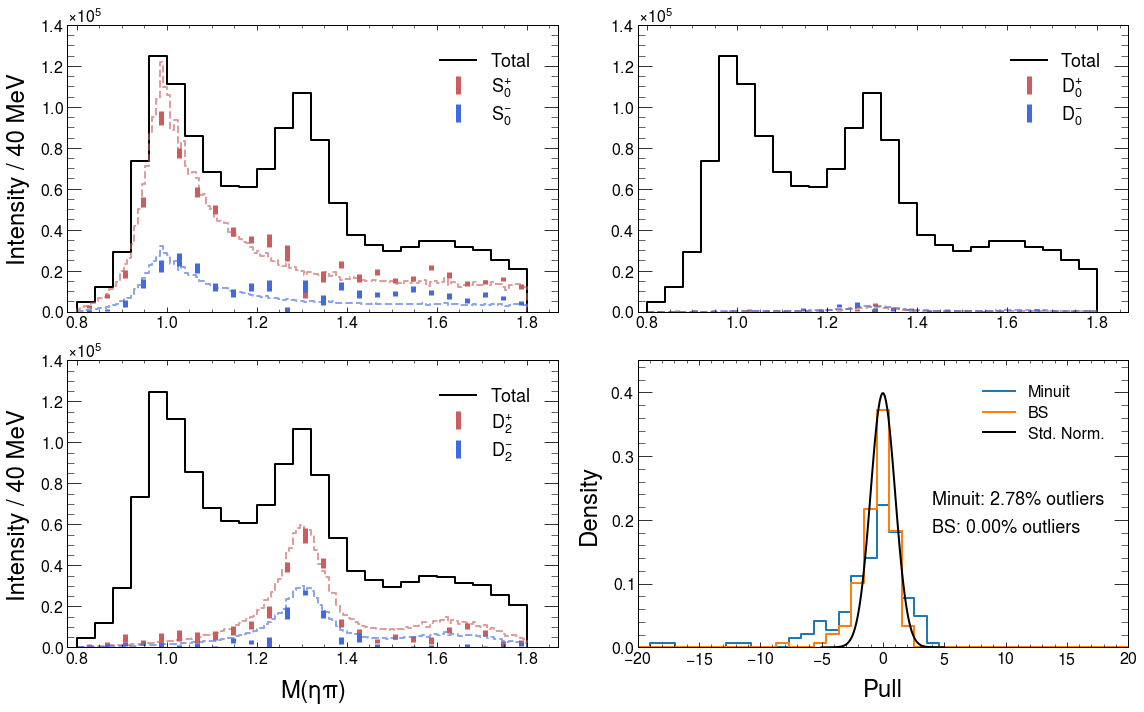

In [22]:
### Overlay kmatrix generated results and save the pulls
axes=plotSpecificAmps(inputDF,mi_df,["S0+","D0+","D2+"],"")

pull_minuit=[]
pull_bs=[]
mi_centers=np.around(mi_df.mass.values,5)

kmatrix_base="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/kmatrix_gen_results/widerBins/"
yieldMap=loadPlotterLog(kmatrix_base)
for i,amp in enumerate(["S0+","D0+","D2+"]):
    for ref,c in zip(["+","-"],["indianred","royalblue"]):
        wave=amp+ref
        binwidth=(inputDF.mass[1]-inputDF.mass[0])
        acc,edges=load_kmatrix(kmatrix_base,wave,yieldMap,binwidth)
        centers=np.around(edges[:-1]+(edges[1]-edges[0])/2,5)
#         axes[i].plot(centers,acc,c=c,linewidth=2, linestyle='--',alpha=0.6)
        hep.histplot(acc,edges,c=c,linewidth=2, linestyle='--',alpha=0.6,ax=axes[i])
        predictions=getMatchingValues(mi_centers,centers,acc)
        pull_minuit.append((mi_df[wave]-predictions)/(mi_df[wave+"_err"]))
        pull_bs.append((mi_df[wave]-predictions)/(ustds[wave+"_err"]+lstds[wave+"_err"])) ## yes its adding ustd and lstd since lstd has implict subtraction
pull_minuit=np.array(pull_minuit).flatten()
pull_bs=np.array(pull_bs).flatten()
        
### Draw the pulls
percentOutside=[]
for pulls,label in zip([pull_minuit,pull_bs],["Minuit","BS"]):
    pulls=pulls[(pulls>np.quantile(pulls,0.02))*(pulls<np.quantile(pulls,0.98))]
    h=np.histogram(pulls,bins=np.linspace(-20,20,40))
    percentOutside.append((1-h[0].sum()/len(pulls))*100)
    hep.histplot(h,ax=axes[3],density=True,label=label)
x = np.linspace(-5, 5, 100)
axes[3].plot(x, stats.norm.pdf(x, 0, 1),c='black',label="Std. Norm.")
axes[3].text(0.6,0.5,"Minuit: {:0.2f}% outliers".format(percentOutside[0]),size=18,transform=axes[3].transAxes)
axes[3].text(0.6,0.40,"BS: {:0.2f}% outliers".format(percentOutside[1]),size=18,transform=axes[3].transAxes)
axes[3].set_ylabel("Density",size=24)
axes[3].set_xlabel("Pull",size=24)
axes[3].legend()

plt.tight_layout()
plt.savefig(ofolder+"/kmatrix_compare_gen_and_pwa_results.pdf")

# GlueX Data

In [50]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

def loadDataInCfgFile(cfg):
    ''' Grab the files listed in a amptools config file '''
    keys=["LOOPDATA","LOOPBKGND","LOOPACCMC"]
    dfs={}
    with open(cfg) as c:
        for line in c.readlines():
            if line.startswith("loop") and "root" in line:
                tmp=line.rstrip().lstrip().split(" ")
                df=[]
                for key in keys:
                    if tmp[1]==key:
                        for f in tmp[2:]:
                            d=loadDF(f,"kin",["Weight","AccWeight","Mpi0eta","cosTheta_eta_hel","cosTheta_eta_gj","Mpi0p","Mpi0","Meta"])
                            if key=="LOOPBKGND":
                                d.Weight*=-1
                            df.append(d)
                        dfs[key]=pd.concat(df)
    return dfs

def plotWaves(floc,mi_df,ofileTag,selectRef=[0,1],resonances=["","p"],
              plotMI=False,plotTheory=False,plotData=True,
              md_color='orange'):
    '''
    md_floc: folder location containing the etapi_plotter root files
    mi_df: dataframe containing the fit results for mass-indep fits
    ofiletag: output file tag to include in the output file name -> positiveRef_[tag].pdf
    refs: where 0,1 represents -,+ reflectivies to plot. i.e. [0,1] will plot both [1] will just plot + ref
    resonaces=["","p"] where ""=a2 or "p"=a2prime or set resonances=["both"] to merge (for mass-indep comparison)
    plotMI: should we plot the mass-independent fit results located in mi_df?
    plotTheroy: should we overlay Vincent's predictions?
    '''
    fileName="etapi_plot_"
    wavesets=np.array([["S0+-","D1--","D0+-","D1+-"],["S0++","D0++","D1++","D2++"]])[selectRef]
    refs=np.array(["negativeRef","positiveRef"])[selectRef]
    naturalities=np.array(["Unnatural\nProduction","Natural\nProduction"])[selectRef]
    xlabel=r"$M(\eta\pi)$ $GeV^2$"
    ylabel=r"Entries / 40 MeV"

    #### Get the maximum value of the D2++ wave in the smallest t-bin so that we can scale all theory curves to it
    histdat, _, width = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapi_40MeVBindat",["000","045","090","135"])
    histacc, _, widthacc = loadMergedPols(floc+"010020/"+fileName+"D2++.root","Metapiacc",["000","045","090","135"])
    binScaleFactor=width/widthacc
    maxD2pp=histacc.max()*binScaleFactor
    theory=constructAltTheory(1)
    scaleFactor=maxD2pp/theory["D2++"].max()
    for iws,waveset,ref,naturality in zip(range(len(wavesets)),wavesets,refs,naturalities):
        fig,axes=plt.subplots(4,5,figsize=(20,14),sharex=True,sharey=True)
        for prime in resonances:
            for iw,wave in enumerate(waveset):
                for it,t,tLabel in zip(range(len(ts)),ts,tLabels):
                    ############### Load the data to be plotted - ok to overwrite histdat and histacc now
                    if wave[0]=="D":
                        selectWave=prime+wave if prime in ["","p"] else wave+"_p"+wave
                        if prime=="":
                            histLabel=f"$a_2(1320)$ ${prettyWave[wave]}$"
                        elif prime=="p":
                            histLabel=f"$a_2(1700)$ ${prettyWave[wave]}$"
                        else:
                            histLabel=f"Mass Dep."
                    else: #All non-D waves
                        selectWave=prime+wave if prime in ["","p"] else wave
                        histLabel=f"${prettyWave[wave]}$"
                    fileLoc=floc+t+"/"+fileName+selectWave+".root"
                    if not os.path.exists(fileLoc):
                        continue
                    histdat,edges,_=loadMergedPols(fileLoc,"Metapi_40MeVBindat",["000","045","090","135"])
                    histbkg,_,_=loadMergedPols(fileLoc,"Metapi_40MeVBinbkg",["000","045","090","135"])
                    values=histdat-histbkg
                    histacc,edgesacc,_=loadMergedPols(fileLoc,"Metapiacc",["000","045","090","135"])
                    valuesacc=histacc*binScaleFactor
                    if plotData:
                        hep.histplot(values,edges,c='black',ax=axes[iw,it])
                    if wave[3]=="+" and (prime=="" or prime=="both"):
                        color="darkgray" if wave[0]=="S" else "orange"
                    if wave[3]=="+" and prime=="p":
                        color="royalblue"
                    if wave[3]=="-" and (prime=="" or prime=="both"):
                        color="darkgray" if wave[0]=="S" else "orange"
                    if wave[3]=="-" and prime=="p":
                        color="royalblue"
                    hep.histplot(valuesacc,edgesacc,color=color,ax=axes[iw,it],alpha=0.8,label=histLabel,histtype='fill')

                    #### Mass independent results
                    if plotMI:
                        mi=mi_df[mi_df.t==t]
                        axes[iw,it].errorbar(mi.mass,mi[wave],yerr=mi[wave+"_err"],c='black',fmt='o',markersize=6,label="Mass Indep.")

                    #### Theory curves
                    if plotTheory:
                        theory=loadTheory(it+1)
                        theory=constructAltTheory(it+1)
                        if wave in theory.columns and prime=="":
                            axes[iw,it].plot(theory.mass,theory[wave].values*scaleFactor,c="mediumseagreen",label="Theory",linewidth=3)
                            
                    ## Draw text with t-bin
                    if iw==0:
                        plt.text(0.15, 1.1, tLabel, fontsize=24, transform=axes[iw,it].transAxes)

                    if it==len(ts)-1:
                        axes[iw,it].legend(prop={"size":18},bbox_to_anchor=(1,0.95))
                    if it==0:
                        maxValInT=max(values)
                    axes[iw,it].set_ylim(0.001,maxValInT*1.2)
                    xmin=edges[:-1][histdat>0][0] # edges has 1 more dimension than the counts, need to account for that
                    xmax=edges[1:][histdat>0][-1]
                    axes[iw,it].set_xlim(xmin,xmax)

        axes[-1,2].set_xlabel(xlabel,size=30)
        axes[1,0].set_ylabel(ylabel,size=30)
        axes[1,0].yaxis.set_label_coords(-0.25, 0.1)
        
        plt.text(0.35, 0.65, naturality, fontsize=24, transform=axes[0,3].transAxes, weight="bold")
        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(ofolder+ref+"_"+ofileTag+".pdf")

loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/010020/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0200325/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/0325050/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/050075/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 650
	t - total entries post filtering 13
loading results in: /d/grid17/ln16/dselector_v3/st

/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


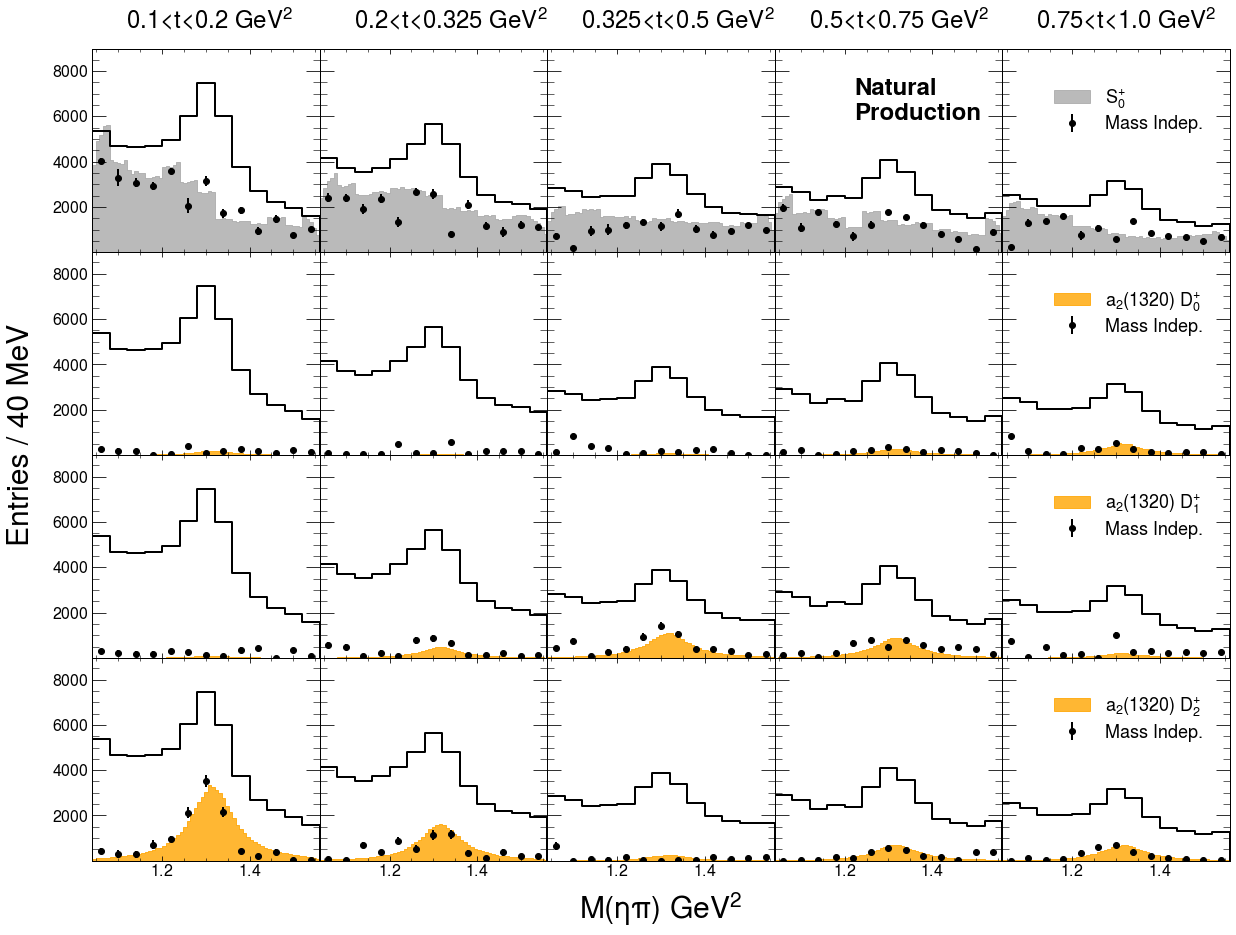

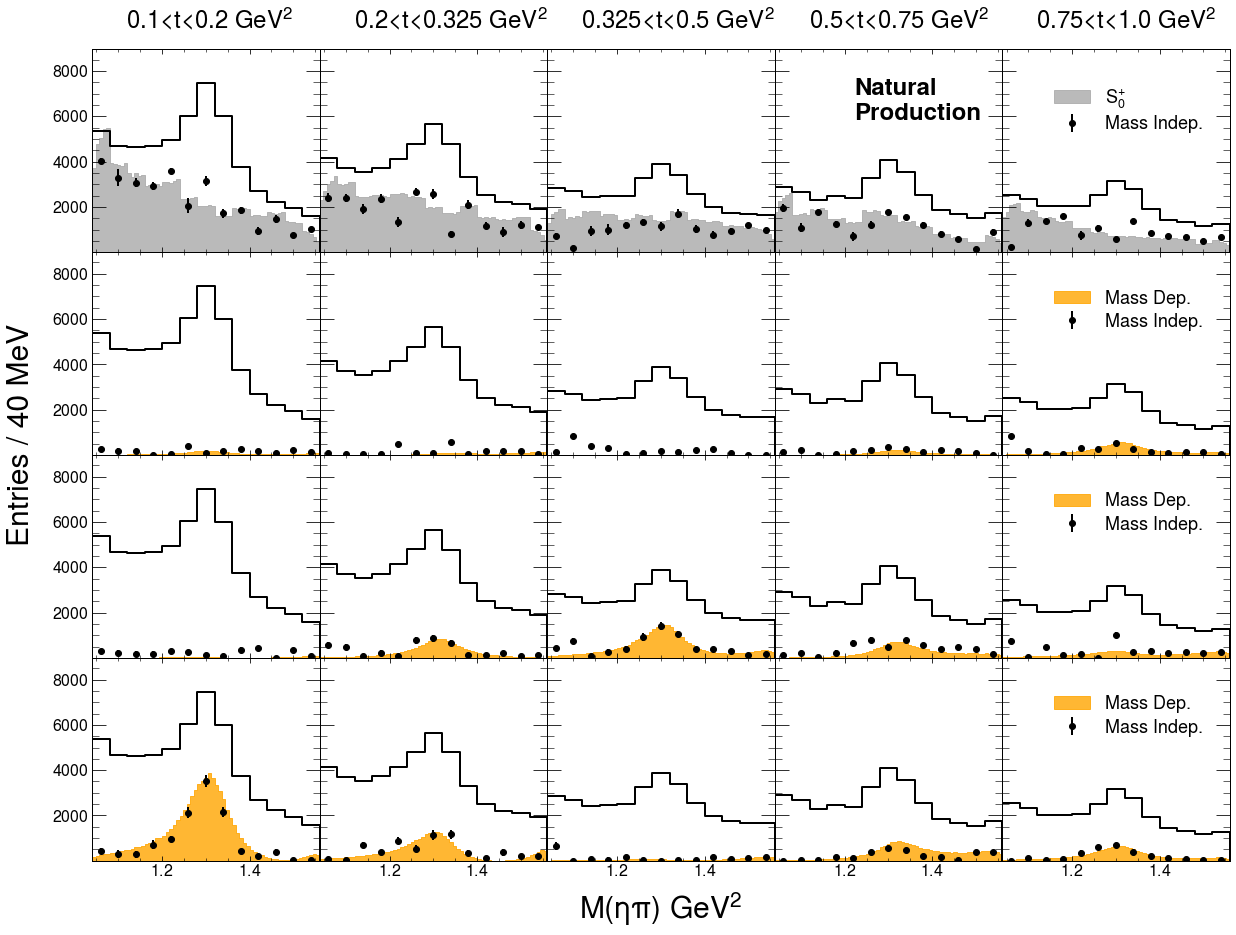

In [52]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.56
mi_nbins=13
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/"
mis=[]
for t in ["010020","0200325",'0325050','050075','075100']:
    mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_m104156_noAccCorr/"
    mi=loadMassIndependentData(mi_floc+t+"/",mi_waveset,
                                  np.linspace(mi_lowMass,mi_upMass,mi_nbins+1))
    mi['t']=t
    mis.append(mi)
mis=pd.concat(mis)

md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"
plotWaves(md_floc,mis,"m104156_a2",selectRef=[1],resonances=[""],plotMI=True,plotTheory=False,plotData=True)
md_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"
plotWaves(md_floc,mis,"m104156_a2a2prime",selectRef=[1],resonances=["both"],plotMI=True,plotTheory=False,plotData=True)

In [53]:
import scipy.stats

def extractValue(floc,search):
    '''
    Extract value given a search string, i.e. bestMinimum in file location, floc
    '''
    with open(floc) as f:
        for line in f.readlines():
            if search in line:
                likelihood=line.split("\t")[-1].rstrip()
                break
    return float(likelihood)

def extractNParameters(floc):
    '''
    Extracting the number of free parameters not really easy, we will search the logs for 
       the specified [search] string and search for npars around there
    input: floc - file location
    output: npars - number of parameters
    '''
    def isNumeric(s):
        if len(s)==0:
            return False
        else:
            return s[0].isdigit()
    
    search="PARAMETER DEFINITIONS"
    with open(floc) as f:
        lines=np.array([ele.rstrip().lstrip() for ele in f.readlines()])
    idx=[i for i in range(len(lines)) if search in lines[i]][0]
    lines=lines[idx:idx+200] # Hopefully there isnt more than 200 parameters...
    lines=[l.split(" ")[0] for l in lines]
    lines=[int(l) for l in lines if l.isnumeric()]
    if np.prod(np.array(lines)==np.arange(len(lines))+1):
        npars=len(lines)
    return npars


def extractPvalue(f1,a1,f2,a2):
    '''
    Extract p-values given 2 file locations and the attempt number
    '''
    min1=extractValue(f1+"etapi_result"+a1+".fit","bestMinimum")
    npar1=extractNParameters(f1+"fitAttempt"+a1+".log")
    min2=extractValue(f2+"etapi_result"+a2+".fit","bestMinimum")
    npar2=extractNParameters(f2+"fitAttempt"+a2+".log")

    deltaLL=min2-min1
    deltaNPars=npar1-npar2
    pvalue=1-stats.chi2.cdf(deltaLL, deltaNPars)
    return deltaLL, deltaNPars, pvalue

def loadLastAttempt(f):
    fs=os.listdir(f)
    attempts=[int(float(f.split("log")[0].split("fitAttempt")[1])) for f in fs if "fitAttempt" in f]
    attempt=max(attempts)
    return str(attempt)

performance=[]
for t in ts:
    f1="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD_includesa2p_bestOutOfTwo/"+t+"/"
    f2="/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/results/phase1_m104156_TMD/"+t+"/"
    a1=loadLastAttempt(f1)
    a2=loadLastAttempt(f2)
    performance.append(extractPvalue(f1,a1,f2,a2))
performance=np.array(performance)

In [54]:
### Alternative to Null
performance=pd.DataFrame(performance,columns=["DeltaLL","DOF","p-value"])
performance["t"]=tLabels
performance=performance[["t","DeltaLL","DOF","p-value"]]
performance

,t,DeltaLL,DOF,p-value
0,0.1<t<0.2 $GeV^2$,124.721544,14.0,0.000000e+00
1,0.2<t<0.325 $GeV^2$,52.233357,14.0,2.567405e-06
2,0.325<t<0.5 $GeV^2$,353.829951,14.0,0.000000e+00
3,0.5<t<0.75 $GeV^2$,100.882494,14.0,3.219647e-15
4,0.75<t<1.0 $GeV^2$,333.504934,14.0,0.000000e+00


# Hybrid Fit Results

In [57]:
#################
# Basic Setup
#################
mi_lowMass=1.04
mi_upMass=1.8
mi_nbins=19
mi_waveset="D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-"
mi_waveset_vec=mi_waveset.split("_")
mi_waveset_vec=[rearrangeWaveNotation[ele] for ele in mi_waveset_vec]

ts=["010020","0200325","0325050","050075","075100"]
midts=[0.15,0.2625,0.4125,0.625,0.875]
tLabels=[f"0.1<t<0.2 $GeV^2$", f"0.2<t<0.325 $GeV^2$", f"0.325<t<0.5 $GeV^2$", f"0.5<t<0.75 $GeV^2$", f"0.75<t<1.0 $GeV^2$"]

md_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/fitResults/" #"/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/fitResults_tbins5_SDDp_allConverged_gausPars_malteSub_includes_a2prime/"
flux_floc="/d/grid17/ln16/dselector_v3/study_pwa/jupyter_plotting/flux/" #"/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/flux/"

#### MI FITS 
mi_floc="/d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/"
mi=loadMassIndependentData(mi_floc,mi_waveset,
                              np.linspace(mi_lowMass,mi_upMass,mi_nbins+1))#,keep=[True,False,False])



loading results in: /d/grid17/ln16/dselector_v3/study_pwa/mass_independent_fits/results/phase1_t010020_m104180_noAccCorr/finalAmps/D-1-_D0+_D0-_D1+_D1-_D2+_S0+_S0-
	t - total entries pre filtering 570
	t - total entries post filtering 19


/d/home/ln16/.local/lib/python3.6/site-packages/ipykernel_launcher.py:119: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


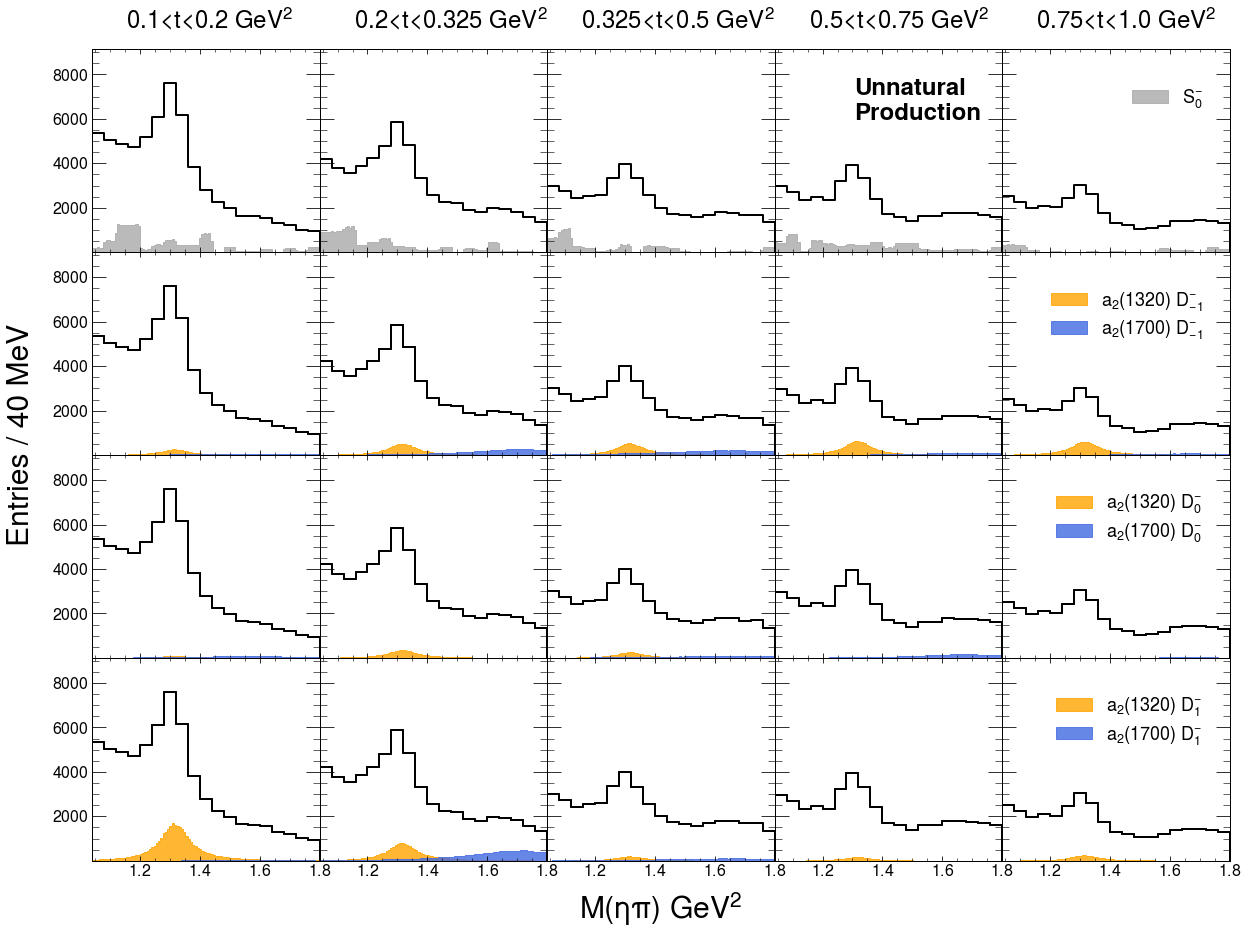

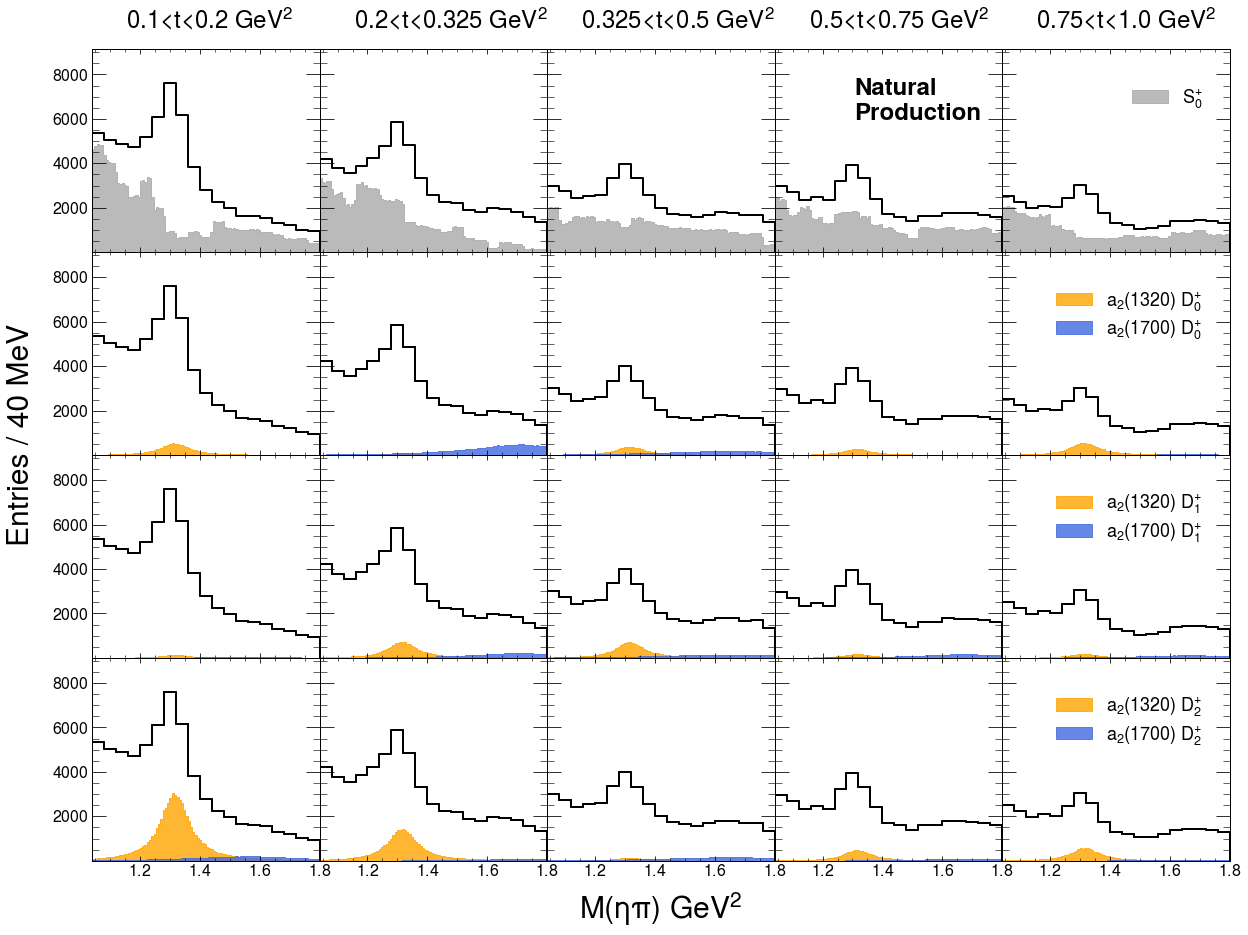

In [58]:
plotWaves(md_floc,mi,"nominal",resonances=["","p"],plotMI=False)

In [59]:
spring_2017_flux=uproot.open(flux_floc+"flux_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux=uproot.open(flux_floc+"flux_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux=uproot.open(flux_floc+"flux_50677_51768.root")["tagged_flux"].values[0]

spring_2017_flux_amo=uproot.open(flux_floc+"flux_AMO_30274_31057.root")["tagged_flux"].values[0]
spring_2018_1_flux_amo=uproot.open(flux_floc+"flux_AMO_40856_42577.root")["tagged_flux"].values[0]
fall_2018_8_flux_amo=uproot.open(flux_floc+"flux_AMO_50677_51768.root")["tagged_flux"].values[0]

phase1_polarized_flux=spring_2017_flux+spring_2018_1_flux+fall_2018_8_flux-spring_2017_flux_amo-spring_2018_1_flux_amo-fall_2018_8_flux_amo
## For the background leakage studies I estimated around 20e13 flux for phase1 between [8,9]. Around 50% of the data would be [8.2,8.8] and
####  then subtracting out around 3% of that does get me around the right number I show below
print(f"phase1 polarized flux: {phase1_polarized_flux:0.3e}")

phase1 polarized flux: 9.367e+13


In [60]:
SDDp_waveInts_ts, SDDp_waveIntErrs_ts, DDp_total = loadFitFractions(md_floc)

In [61]:
## YIELDS
###### DDp_total of around 450k is about the right number if we manually acceptance correct the yield in t=010020 range. Can look at 
############# drawAmptoolsVar.C program
accCorrected_D=SDDp_waveInts_ts["D"]*DDp_total
accCorrectedErr_D=SDDp_waveIntErrs_ts["D"]*DDp_total
accCorrected_Dpos=np.array([v for k,v in SDDp_waveInts_ts.items() if k[0]=="D" and k[-1]=="+"]).sum(axis=0)*DDp_total
accCorrectedErr_Dpos=np.sqrt(np.power(np.array([v for k,v in SDDp_waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="+"]),2).sum(axis=0))*DDp_total
accCorrected_Dneg=np.array([v for k,v in SDDp_waveInts_ts.items() if k[0]=="D" and k[-1]=="-"]).sum(axis=0)*DDp_total
accCorrectedErr_Dneg=np.sqrt(np.power(np.array([v for k,v in SDDp_waveIntErrs_ts.items() if k[0]=="D" and k[-1]=="-"]),2).sum(axis=0))*DDp_total

### EXTRA
a2_br=[0.145,0.012]
a2prime_br=[0.036,0.011]
eta_br=[0.3941,0.002]
pi0_br=[0.98823,0.00034]
a2FullReact_br=combineBR(a2_br,eta_br,pi0_br)
a2primeFullReact_br=combineBR(a2prime_br,eta_br,pi0_br)
target=1.22*1e-9
xerrs=[0.05,0.0625,0.0875,0.125,0.125]
tBinWidths=np.array([0.1,0.125,0.175,0.25,0.25])

### CALCULATE CROSS SECTION
## Polarized flux basically no error bars 
crossSection=accCorrected_D/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionErr=crossSection*np.sqrt( 
    (accCorrectedErr_D/accCorrected_D)*(accCorrectedErr_D/accCorrected_D)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionPos=accCorrected_Dpos/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionPosErr=crossSectionPos*np.sqrt( 
    (accCorrectedErr_Dpos/accCorrected_Dpos)*(accCorrectedErr_Dpos/accCorrected_Dpos)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )
crossSectionNeg=accCorrected_Dneg/phase1_polarized_flux/target/a2FullReact_br[0]/tBinWidths
crossSectionNegErr=crossSectionNeg*np.sqrt( 
    (accCorrectedErr_Dneg/accCorrected_Dneg)*(accCorrectedErr_Dneg/accCorrected_Dneg)+
    (a2FullReact_br[1]/a2FullReact_br[0])*(a2FullReact_br[1]/a2FullReact_br[0])
                                    )

# nb to microbarns
crossSection/=1000
crossSectionErr/=1000
crossSectionPos/=1000
crossSectionPosErr/=1000
crossSectionNeg/=1000
crossSectionNegErr/=1000

parityAsym=(crossSectionPos-crossSectionNeg)/(crossSectionPos+crossSectionNeg)
parityAsymErr=np.sqrt(
    np.power((2*crossSectionNeg/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionPosErr),2)+
    np.power((2*crossSectionPos/np.power(crossSectionPos+crossSectionNeg,2)*crossSectionNegErr),2)
)

In [62]:
bapa_theory=pd.read_csv("/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/Ten_A2_Fit_85GeV.txt",delimiter=";")
bapa_theory=bapa_theory[["beam asymmetry","parity asymmetry"]]
bapa_theory.columns=["ba","pa"]
crossSection_theory=pd.read_csv("/d/grid17/ln16/myDSelector/amptools/mass_dep_fits/Bands_TMD_A2.txt", delim_whitespace=True, header=None)
crossSection_theory=crossSection_theory.loc[:,[0,7,8,9]]
crossSection_theory.columns=["t","cs_low_err","cs","cs_up_err"]
crossSection_theory=pd.concat([crossSection_theory,bapa_theory],axis=1)
crossSection_theory["cs_low_err"]=crossSection_theory["cs"]-crossSection_theory["cs_low_err"]
crossSection_theory["cs_up_err"]=crossSection_theory["cs_up_err"]-crossSection_theory["cs"]
crossSection_theory=crossSection_theory[(crossSection_theory.t<1)&(crossSection_theory.t>0.1)]

Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


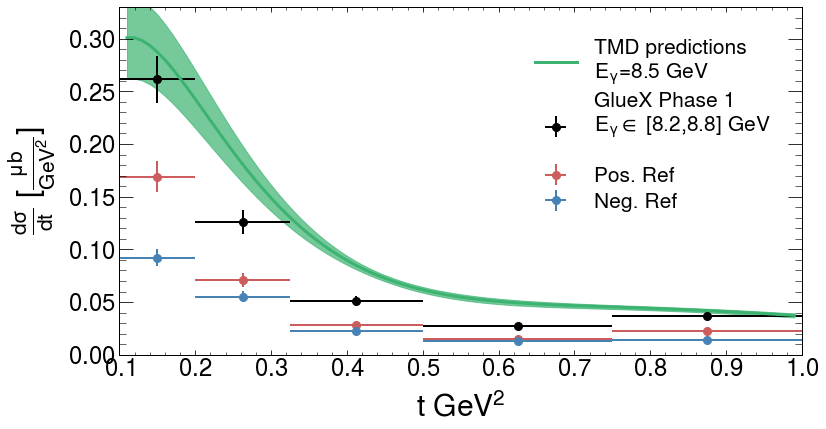

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


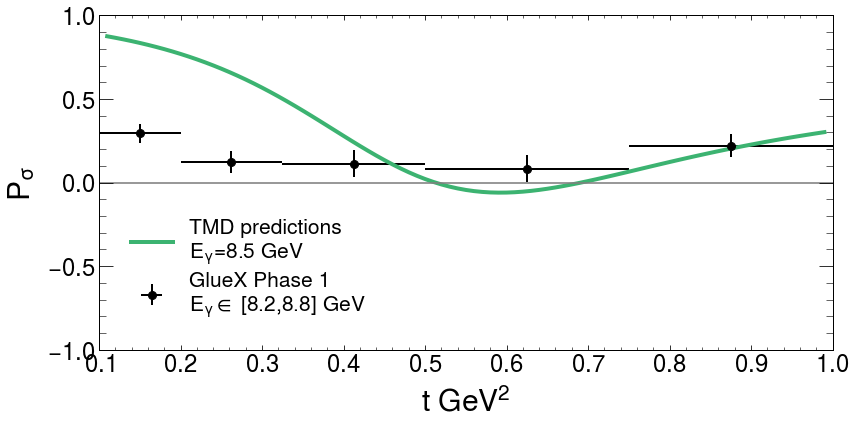

In [63]:
fig,axes=plt.subplots(1,1,figsize=(12,6))

arbitraryFactor=1
axes.errorbar(midts,crossSection,fmt='o',xerr=xerrs,yerr=crossSectionErr,c='black',
                 label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV\n")
axes.errorbar(midts,crossSectionPos,fmt='o',xerr=xerrs,yerr=crossSectionPosErr,c='indianred',label="Pos. Ref")
axes.errorbar(midts,crossSectionNeg,fmt='o',xerr=xerrs,yerr=crossSectionNegErr,c='steelblue',label="Neg. Ref")
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$\frac{d\sigma}{dt}$ [$\frac{\mu b}{GeV^2}$]",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["cs"]/arbitraryFactor,c="mediumseagreen",linewidth=3,
             label="TMD predictions\n$E_{\gamma}$=8.5 GeV")
axes.fill_between(crossSection_theory["t"],
                      (crossSection_theory["cs"]-crossSection_theory["cs_low_err"])/arbitraryFactor,
                      (crossSection_theory["cs"]+crossSection_theory["cs_up_err"])/arbitraryFactor,
                      color="mediumseagreen",alpha=0.7)
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(0,0.33)
axes.ticklabel_format(style='plain')
axes.legend(prop={"size":21})
plt.savefig("a2_xsec_m104180.pdf")

fig,axes=plt.subplots(1,1,figsize=(12,6))
axes.errorbar(midts,parityAsym,fmt='o',xerr=xerrs,yerr=parityAsymErr,c='black',label="GlueX Phase 1\n$E_{\gamma}\in$ [8.2,8.8] GeV")
axes.tick_params(axis='both',labelsize=24)
axes.set_xlabel(r"t $GeV^2$",size=30)
axes.set_ylabel(r"$P_{\sigma}$",size=30)
axes.plot(crossSection_theory["t"],crossSection_theory["pa"],c="mediumseagreen",linewidth=4,label="TMD predictions \n$E_{\gamma}$=8.5 GeV")
axes.tick_params(axis='both',labelsize=24)
axes.set_xlim(0.1)
axes.set_ylim(-1,1)
axes.legend(prop={"size":21})
axes.axhline(0,c='gray',alpha=0.8,linestyle='-')

plt.tight_layout()

plt.savefig("a2_parityAsym_m104180.pdf")